## Supervised learning Evaluation 

### 1. Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import csv
#ata=pd.read_csv('Medicaldataset.csv',sep=',', skiprows=0)
data=pd.read_csv('Medicaldataset.csv')
data = data[data['Heart rate'] < 500]

In [3]:
data['Result'].replace(['negative', 'positive'],
                        [0, 1], inplace=True)
data['Blood sugar'] = data['Blood sugar'].apply(lambda x: 1 if x > 120 else 0)
data.head()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,160,83,1,1.80,0.012,0
1,21,1,94,98,46,1,6.75,1.060,1
2,55,1,64,160,77,1,1.99,0.003,0
3,64,1,70,120,55,1,13.87,0.122,1
4,55,1,64,112,65,1,1.08,0.003,0


### 2. Model Evaluation_Random Forest

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import recall_score, accuracy_score,roc_curve, auc,mean_squared_error, mean_absolute_error
from sklearn.metrics import (
    accuracy_score, roc_auc_score, recall_score, 
    mean_absolute_error, precision_score, f1_score)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

X = data.drop('Result', axis=1)
y = data['Result']
y_encoded = label_encoder.fit_transform(data['Result'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.25, random_state=42)

### 2.1 Feature importance analysis

In [6]:
!pip install shap

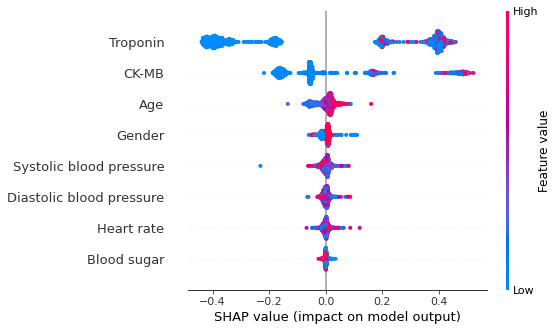

In [7]:
import shap

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# SHAP beeswarm plot
shap.summary_plot(shap_values[1], X, plot_type="dot")

### 2. 2 Feature ablation

In [8]:
model = RandomForestClassifier(max_depth=2,n_estimators=100, min_samples_split=2, random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Overall accuracy with 10-fold CV
y_pred = cross_val_predict(model, X, y, cv=kf, method='predict')
overall_accuracy = accuracy_score(y, y_pred)
print("Overall Accuracy:", overall_accuracy)

# Feature ablation analysis
feature_accuracies = {}
feature_std_devs = {}

for feature in X.columns:
    X_ablated = X.drop(feature, axis=1)
 
    fold_accuracies = []
    
    for train_index, val_index in kf.split(X_ablated):
        X_train, X_val = X_ablated.iloc[train_index], X_ablated.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        model.fit(X_train, y_train)
        y_pred_fold = model.predict(X_val)
        fold_accuracy = accuracy_score(y_val, y_pred_fold)
        fold_accuracies.append(fold_accuracy)
    
    mean_accuracy = np.mean(fold_accuracies)
    std_accuracy = np.std(fold_accuracies)
    
    feature_accuracies[feature] = mean_accuracy
    feature_std_devs[feature] = std_accuracy

# Feature ablation analysis results
print("\nFeature Ablation Analysis Results:")
for feat, acc in feature_accuracies.items():
    std = feature_std_devs[feat]
    print(f"{feat}: {acc:.4f} ± {std:.4f}")

Overall Accuracy: 0.986322188449848

Feature Ablation Analysis Results:
Age: 0.9863 ± 0.0126
Gender: 0.9863 ± 0.0126
Heart rate: 0.9863 ± 0.0126
Systolic blood pressure: 0.9863 ± 0.0126
Diastolic blood pressure: 0.9863 ± 0.0126
Blood sugar: 0.9863 ± 0.0126
CK-MB: 0.8716 ± 0.0236
Troponin: 0.7044 ± 0.0381


### 2.3  Sensitive Analysis_ learning curve/hyperparameter sensitivy analysis

### learning curve

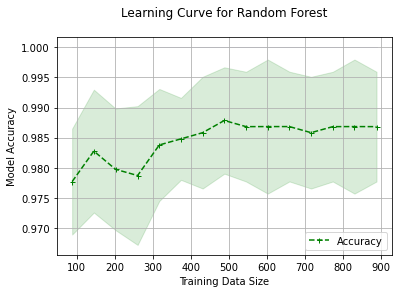

In [9]:
features = data.columns[:-1]
X = data[features]
y = data['Result']

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.25, stratify=y, random_state=1)

# Create a pipeline with RandomForest
pipeline = make_pipeline(
    StandardScaler(),  
    RandomForestClassifier(n_estimators=100, random_state=1)  
)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline, 
    X=X_train, 
    y=y_train,
    cv=10,  
    train_sizes=np.linspace(0.1, 1.0, 15),  
    n_jobs=-1  
)

# Calculate training and test mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='navy')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve for Random Forest\n')
plt.xlabel('Training Data Size')
plt.ylabel('Model Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

#### Hyperparameter sensitivity analysis _max_depth

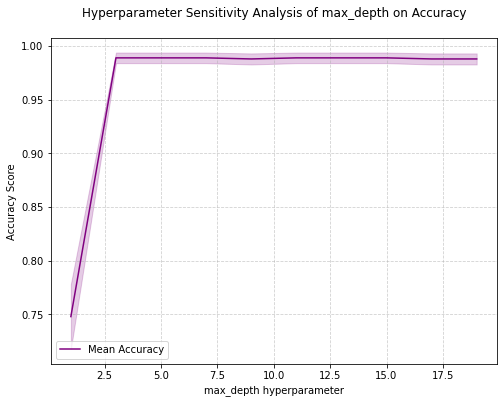

In [10]:

max_depth_range = range(1, 20, 2)

mean_accuracy_scores = []
std_accuracy_scores = []

for depth in max_depth_range:
    model = RandomForestClassifier(max_depth=depth, n_estimators=100, random_state=42)
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_accuracy_scores.append(np.mean(cv_scores))
    std_accuracy_scores.append(np.std(cv_scores))

plt.figure(figsize=(8, 6))
plt.plot(max_depth_range, mean_accuracy_scores, label='Mean Accuracy', color='purple')
plt.fill_between(max_depth_range, 
                 np.array(mean_accuracy_scores) - np.array(std_accuracy_scores),
                 np.array(mean_accuracy_scores) + np.array(std_accuracy_scores),
                 color='purple', alpha=0.2, )
plt.title('Hyperparameter Sensitivity Analysis of max_depth on Accuracy\n')
plt.xlabel('max_depth hyperparameter')
plt.ylabel('Accuracy Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

#### Hyperparameter sensitivity analysis _n estimators

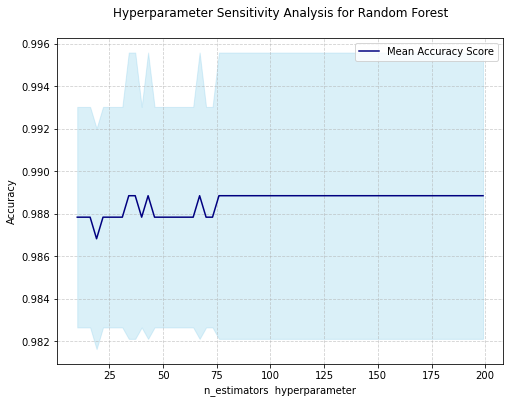

In [11]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)
param_grid = {
    'n_estimators': range(10, 200, 3)}
fixed_params = {
    'max_depth': 20,  
    'min_samples_split': 2, 
    'min_samples_leaf': 1,
    'max_features':'sqrt'
}

# Initialize Random Forest model
model = RandomForestClassifier(random_state=42)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)

# Convert to numeric data types
results['param_n_estimators'] = pd.to_numeric(results['param_n_estimators'], errors='coerce')
results['mean_test_score'] = pd.to_numeric(results['mean_test_score'], errors='coerce')
results['std_test_score'] = pd.to_numeric(results['std_test_score'], errors='coerce')

results = results.sort_values(by='param_n_estimators')

# plot
plt.figure(figsize=(8, 6))
plt.plot(results['param_n_estimators'], results['mean_test_score'], color='navy', label='Mean Accuracy Score')
plt.fill_between(
    results['param_n_estimators'],
    results['mean_test_score'] - results['std_test_score'],  
    results['mean_test_score'] + results['std_test_score'],  
    color='skyblue', alpha=0.3
)
plt.xlabel('n_estimators  hyperparameter')
plt.ylabel('Accuracy')
plt.title('Hyperparameter Sensitivity Analysis for Random Forest\n')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

### 3 Failure analysis

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Generate predictions
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9787234042553191
Confusion Matrix:
 [[122   2]
 [  5 200]]


### 3.1 Plot the confusion matrix

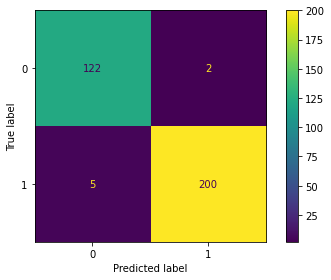

In [13]:
plot_confusion_matrix(model, X_test, y_test)        
plt.tight_layout() 
plt.show()

### 3.2 SHAP force plot

In [14]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
misclassified = results[results['Actual'] != results['Predicted']]

df=pd.DataFrame(misclassified)
df=df.reset_index()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42)

misclassified_indices=df['index'].tolist()
X_test_reset=X_test.reset_index()
misclassified_data = X_test_reset.loc[misclassified_indices]  

misclassified_data['Actual'] = y_test[misclassified_indices]
misclassified_data['Predicted'] = y_pred[misclassified_indices]
misclassified_data

,index,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Actual,Predicted
17,44,63,1,91,121,82,0,4.220,0.008,1,0
143,209,60,1,68,42,64,0,0.879,0.426,0,1
166,29,63,1,66,135,55,1,0.493,10.000,0,1
199,232,51,0,74,120,70,1,5.160,0.003,1,0
213,999,29,0,74,223,118,0,4.930,0.003,1,0
253,1008,27,1,94,157,79,1,6.250,0.003,1,0
268,200,47,0,67,128,92,0,5.270,0.010,1,0



Analysis for Misclassified Example 17:
Actual: 1, Predicted: 0


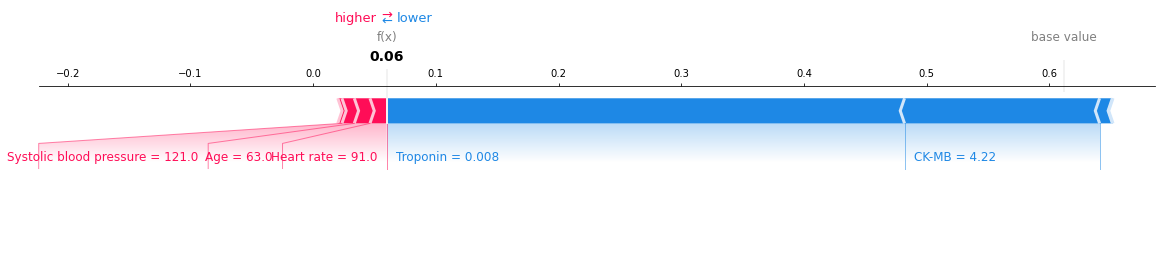


Analysis for Misclassified Example 143:
Actual: 0, Predicted: 1


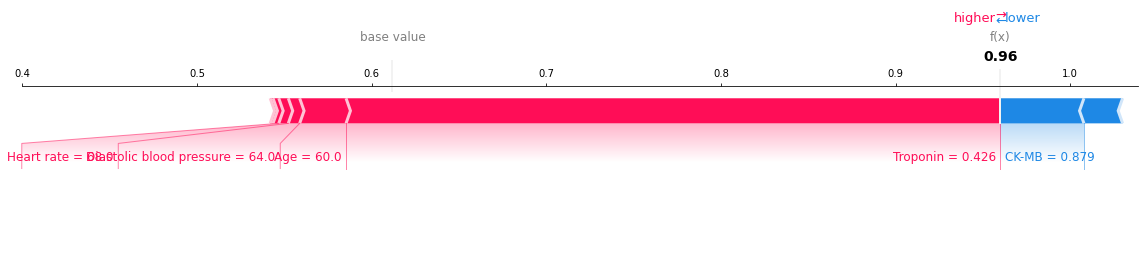


Analysis for Misclassified Example 166:
Actual: 0, Predicted: 1


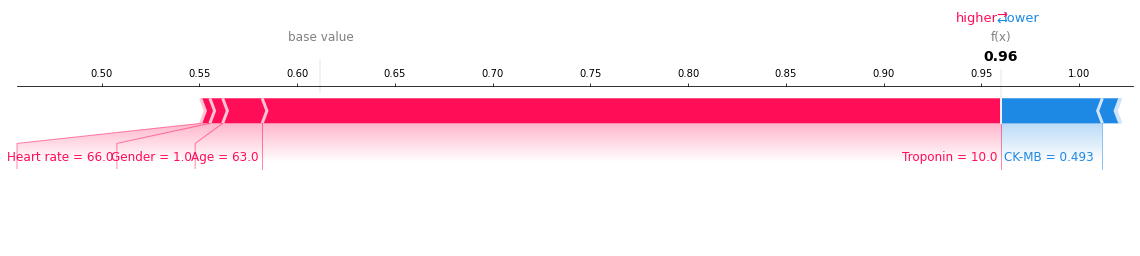


Analysis for Misclassified Example 199:
Actual: 1, Predicted: 0


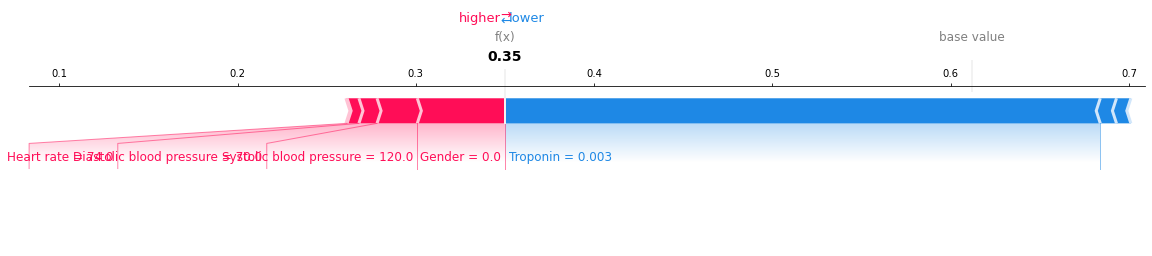


Analysis for Misclassified Example 213:
Actual: 1, Predicted: 0


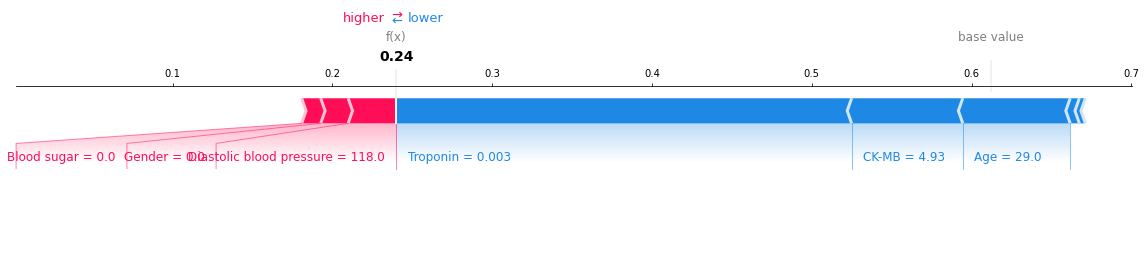


Analysis for Misclassified Example 253:
Actual: 1, Predicted: 0


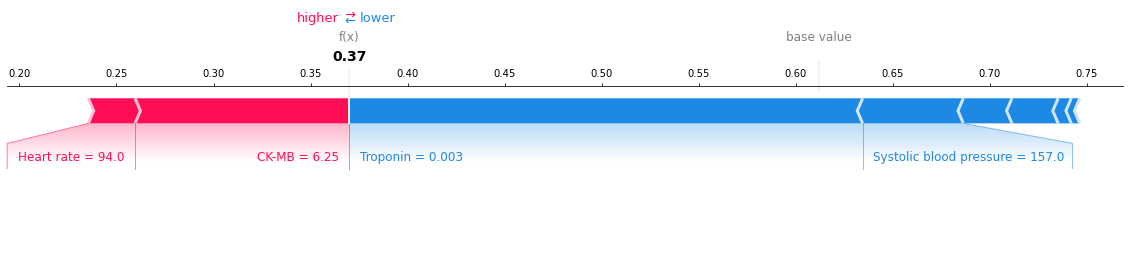


Analysis for Misclassified Example 268:
Actual: 1, Predicted: 0


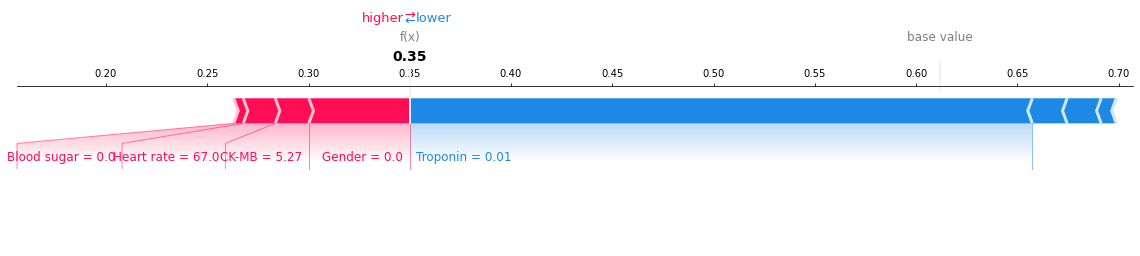

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

for index in misclassified_data.index:
    print(f"\nAnalysis for Misclassified Example {index}:")
    print(f"Actual: {misclassified.loc[index, 'Actual']}, Predicted: {misclassified.loc[index, 'Predicted']}")
    shap.force_plot(
        explainer.expected_value[1],  # Expected value for class 1
        shap_values[1][X_test_reset.index.get_loc(index), :],  # SHAP values for class 1
        X_test_reset.loc[index, :][1:],  # Feature values for the example
        matplotlib=True  # Use matplotlib for rendering
    )